In [1]:
# general purpose libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# torch libraries
import torch
import torch.nn as nn
import torchmetrics
from torcheval.metrics.functional import binary_auprc

# model libraries
from neural_net_pre_process import RNAData

In [2]:
DATA_PATH = os.path.join(".", "data", "dataset0.json.gz")
TEST1_PATH = os.path.join(".", "data", "dataset1.json.gz")
TEST2_PATH = os.path.join(".", "data", "dataset2.json.gz")
LABEL_PATH = os.path.join(".", "data", "data.info")
BATCH_SIZE = 128
READ_SIZE = 20
TRAIN_SIZE = 0.8  # Specify the training size if you're using train-test split

rna_data = RNAData(data_path=DATA_PATH, label_path=LABEL_PATH, batch_size=BATCH_SIZE, read_size=READ_SIZE, train=True, train_size=TRAIN_SIZE)

Currently pre processing ...
Pre processing done!
Currently labelling ...
Labelling done
Currently Splitting ...
Splitting done
Currently encoding ...
Encoding done


In [11]:
# Switch to train mode
rna_data.train_mode()
    
# Get training data
train_data_loader = rna_data.data_loader()
    
 # Extract features (X) and labels (y) for training
X_train, y_train = zip(*[batch for batch in train_data_loader])
X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

# Switch to eval mode
rna_data.eval_mode()

# Get test data
test_data_loader = rna_data.data_loader()
    
# Extract features (X) and labels (y) for testing
X_test, y_test = zip(*[batch for batch in test_data_loader])
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

In [14]:
X_test.shape

torch.Size([24339, 20, 12])

In [21]:
transcript_pos_0 = rna_data.test_transcript_position
len(transcript_pos_0)

24339

In [25]:
type(rna_data)

neural_net_pre_process.RNAData

In [28]:
len(test_dataset_1.train_transcript_position)

90810

In [66]:
# Create an instance of the RNAData class for the test data (no labels)
test_dataset_0 = RNAData(data_path=DATA_PATH, train=False)

# Create a DataLoader for the test data
test_dataloader_0 = test_dataset_0.data_loader()

# Initialize an empty list to store X_test
X_test_0 = []
indices = []

# Iterate through the DataLoader to load X_test
for X, index in test_dataloader_0:
    # X contains the features for the current batch
    X_test_0.append(X)
    # index contains the index in which the site from in the train_transcript_position
    indices.extend(index)

# finding out the transcript_id and position of each train value
rna_test0_sites = test_dataset_0.train_transcript_position
test0_transcript_ids = list(map(lambda x : rna_test0_sites[x][0], indices))
test0_transcript_position = list(map(lambda x : rna_test0_sites[x][1], indices))


# Concatenate the lists to get the full X_test
X_test_0 = torch.cat(X_test_0)

Currently pre processing ...
Pre processing done!
Currently encoding ...
Encoding done


In [29]:
# Create an instance of the RNAData class for the test data (no labels)
test_dataset_1 = RNAData(data_path=TEST1_PATH, train=False)

# Create a DataLoader for the test data
test_dataloader_1 = test_dataset_1.data_loader()

# Initialize an empty list to store X_test
X_test_1 = []
indices = []

# Iterate through the DataLoader to load X_test
for X, index in test_dataloader_1:
    # X contains the features for the current batch
    X_test_1.append(X)
    # index contains the index in which the site from in the train_transcript_position
    indices.extend(index)

# finding out the transcript_id and position of each train value
rna_test1_sites = test_dataset_1.train_transcript_position
test1_transcript_ids = list(map(lambda x : rna_test1_sites[x][0], indices))
test1_transcript_position = list(map(lambda x : rna_test1_sites[x][1], indices))


# Concatenate the lists to get the full X_test
X_test_1 = torch.cat(X_test_1)

Currently pre processing ...
Pre processing done!
Currently encoding ...
Encoding done


In [33]:
#  Create an instance of the RNAData class for the test data (no labels)
test_dataset_2 = RNAData(data_path=TEST2_PATH, train=False)

# Create a DataLoader for the test data
test_dataloader_2 = test_dataset_2.data_loader()

# Initialize an empty list to store X_test
X_test_2 = []
indices = []

# Iterate through the DataLoader to load X_test
for X, index in test_dataloader_2:
    # X contains the features for the current batch
    X_test_2.append(X)
    # index contains the index in which the site from in the train_transcript_position
    indices.extend(index)

# finding out the transcript_id and position of each train value
rna_test2_sites = test_dataset_2.train_transcript_position
test2_transcript_ids = list(map(lambda x : rna_test2_sites[x][0], indices))
test2_transcript_position = list(map(lambda x : rna_test2_sites[x][1], indices))

# Concatenate the lists to get the full X_test
X_test_2 = torch.cat(X_test_2)

Currently pre processing ...
Pre processing done!
Currently encoding ...
Encoding done


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.15      0.26     23107
           1       0.05      0.90      0.10      1232

    accuracy                           0.19     24339
   macro avg       0.51      0.52      0.18     24339
weighted avg       0.92      0.19      0.25     24339

ROC AUC Score: 0.5755111630590382
PRC AUC Score: 0.06282863587974893


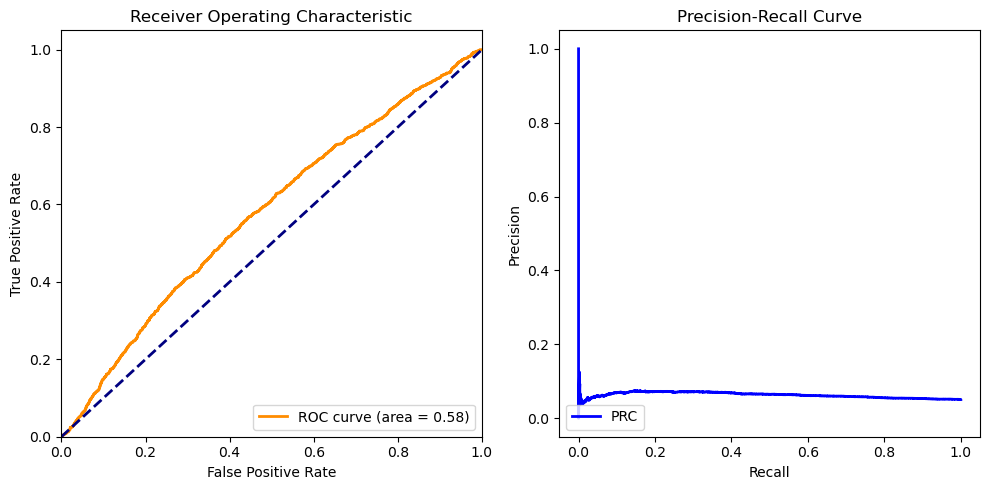

In [127]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch

def xgboost_classification(X_train, y_train, X_test, y_test, params):
    """
    Perform XGBoost classification, evaluate the model, and plot ROC and PRC curves.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.
    params (dict): Dictionary of XGBoost hyperparameters.

    Returns:
    None
    """

    X_train_exp = X_train.view(-1, 12).numpy()
    X_test_exp = X_test.view(-1, 12).numpy()
    y_train_exp = y_train.repeat(20).numpy()

    # Create an XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(**params)

    # Fit the XGBoost model
    xgb_classifier.fit(X_train_exp, y_train_exp)

    # Predict probabilities
    y_pred_prob = xgb_classifier.predict_proba(X_test_exp)[:, 1]

    #Calculate probabilities for each site
    new = y_pred_prob.reshape(int(len(y_pred_prob))//20, 20)
    y_pred_prob_sim = np.mean(new, axis=1)

    # Predict labels
    y_pred = (y_pred_prob_sim >= 0.5).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sim)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_sim)

    # Calculate the area under the Precision-Recall Curve (PRC)
    prc_auc = average_precision_score(y_test, y_pred_prob_sim)

    # Print ROC AUC score
    print('ROC AUC Score:', roc_auc)

    # Print PRC score
    print('PRC AUC Score:', prc_auc)

    # Plot ROC and PRC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return y_pred_prob_sim, xgb_classifier

# Define your XGBoost hyperparameters
xgboost_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 1,
}

# Call the XGBoost classification function
y_pred_proba_0, model = xgboost_classification(X_train, y_train, X_test, y_test, xgboost_params)


In [125]:
X_train.shape

torch.Size([97499, 20, 12])

In [96]:
type(y_pred_proba_0

numpy.ndarray

In [67]:
# Predict probabilities
y_pred_proba_0 = model.predict_proba(X_test_0.view(X_test_0.size(0), -1))[:, 1]
y_pred_proba_1 = model.predict_proba(X_test_1.view(X_test_1.size(0), -1))[:, 1]
y_pred_proba_2 = model.predict_proba(X_test_2.view(X_test_2.size(0), -1))[:, 1]


In [68]:
data_0 = {'transcript_id': test0_transcript_ids, 'transcript_position':test0_transcript_position, 'score':y_pred_proba_0}
df_0 = pd.DataFrame(data_0)

df_0.head(5)

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.225600
1,ENST00000000233,261,0.260364
2,ENST00000000233,316,0.115148
3,ENST00000000233,332,0.311586
4,ENST00000000233,368,0.319416


In [58]:
data_1 = {'transcript_id': test1_transcript_ids, 'transcript_position':test1_transcript_position, 'score':y_pred_proba_1}
df_1 = pd.DataFrame(data_1)

df_1.head(5)

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.117601
1,ENST00000000233,261,0.189848
2,ENST00000000233,316,0.071894
3,ENST00000000233,332,0.413240
4,ENST00000000233,368,0.356644


In [59]:
data_2 = {'transcript_id': test2_transcript_ids, 'transcript_position':test2_transcript_position, 'score':y_pred_proba_2}
df_2 = pd.DataFrame(data_2)

df_2.head(5)

,transcript_id,transcript_position,score
0,tx_id_0,0,0.055808
1,tx_id_0,10,0.984248
2,tx_id_0,20,0.956633
3,tx_id_0,30,0.983767
4,tx_id_0,40,0.523352


In [69]:
FILE_PATH_0 = r'c:\Users\jonas\OneDrive\Desktop\Work\Coding\Projects\dsa4266_ribosomes\ribosomes_dataset0_2.csv'
FILE_PATH_1 = r'c:\Users\jonas\OneDrive\Desktop\Work\Coding\Projects\dsa4266_ribosomes\ribosomes_dataset1_2.csv'
FILE_PATH_2 = r'c:\Users\jonas\OneDrive\Desktop\Work\Coding\Projects\dsa4266_ribosomes\ribosomes_dataset2_2.csv'

df_0.to_csv(FILE_PATH_0, index=False)
df_1.to_csv(FILE_PATH_1, index=False)
df_2.to_csv(FILE_PATH_2, index=False)

In [70]:
print(df_0.shape)
print(df_1.shape)
print(df_2.shape)

(121838, 3)
(90810, 3)
(1323, 3)
